In [1]:
import warnings

# Filter out the specific warning message
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.")



# Analysis concept  
1. Comparison of the three datasets  
        Impact of sample prep on protein level and prediction level
2. How similar is a complete organoid to Brain? (No single cell)  
        - MLMarker  
        - comparison to brain tissue    
        - comparison to brain cell line  
3. How different are the single cells within the organoid?  


In [2]:
import MLMarker_app
import pandas as pd
import numpy as np
from MLMarker_app import MLMarker
import matplotlib.pyplot as plt
import random

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 1. Evo96 entire organoid protein analysis. How close is this to brain?  
We'll use the SHAP values. This will give each protein a metric showing its contribution to a prediction of a tissue. A positive SHAP value means the protein is pushing that tissue prediction, a negative SHAP value means it is against that tissue prediction.  
*important remarkt*: This is based on proteins it was trained upon, a lot of training proteins are not within the dataset so these are added as value zero. while the identified proteins have an abundance of 1. This means we need to be careful with interpretation!
### First reduce to only the SHAP != 0

In [3]:
#all proteins combined
df = pd.read_csv("evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv", sep='\t')
proteins = np.array(df[["Protein.Ids"]].values.tolist()).flatten()
# if it contains ';' split it and take both
proteins = [x.split(';') for x in proteins]
proteins = [item for sublist in proteins for item in sublist]
proteins = list(set(proteins))

#make a dataframe with the proteins as column names, only one row and all values 1
data = np.ones((1, len(proteins)))
predict_df = pd.DataFrame(data, columns=proteins)

test = MLMarker(predict_df.iloc[0:1,:], binary = True)
prediction = MLMarker.predict_top_tissues(test)
prediction

[('Testis', 0.2011),
 ('Retina', 0.1445),
 ('Parotid gland', 0.0651),
 ('Brain', 0.063),
 ('Adipose tissue', 0.0546)]

In [4]:
shap_df = MLMarker.shap_values_df(test, n_preds=5).reset_index()
shap_df.set_index('tissue', inplace=True)
shap_df

,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6K5,A0A075B6Q5,A0A075B6R2,A0A075B6S4,A0A075B6S5,A0A087WSY6,...,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X0,Q9Y6X3,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
tissue,,,,,,,,,,,,,,,,,,,,,
Testis,0.000039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Retina,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Parotid gland,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brain,0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adipose tissue,-0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
shap_df.shape
shap_df = shap_df.loc[:, (shap_df != 0).any(axis=0)]
shap_df.shape


(5, 1176)

From the 6 877 proteins in the model (including identified and added proteins) there are 1 176 that have a SHAP value in the top 5 predicted tissues. How are these distributed amongst these tissues?

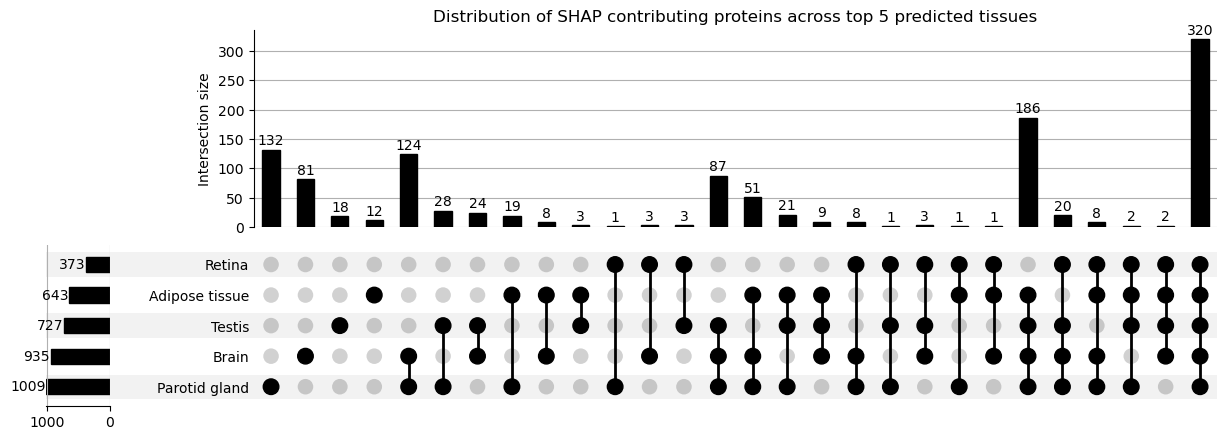

In [6]:
from upsetplot import UpSet

#drop columns with all zeros
shap_df = shap_df.loc[:, (shap_df != 0).any(axis=0)].copy()

binary_df = (shap_df != 0).astype(int)

# Transpose the dataframe so that proteins are the index and tissues are the columns
binary_df = binary_df.T.copy()

# Group by combinations of tissues and count occurrences of proteins
protein_sets = binary_df.groupby(list(binary_df.columns)).size()

# Create the upset plot
upset = UpSet(protein_sets, show_counts=True)
upset.plot()
plt.title('Distribution of SHAP contributing proteins across top 5 predicted tissues')

# Show the plot
plt.show()



##  Compare present vs absent  
We need to be cautious of the contribution of present vs absent proteins. But how many are there?

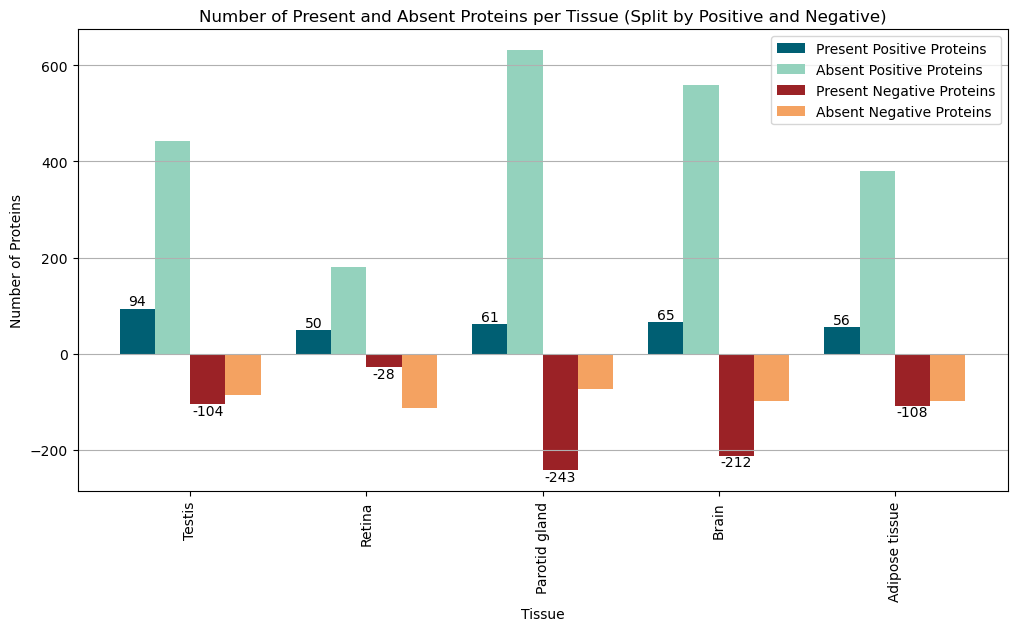

In [7]:
import pandas as pd
import numpy as np

# Determine which proteins (columns) are present in the 'proteins' list
present_mask = shap_df.columns.isin(proteins)

# Split present proteins into positive and negative counts for each tissue
present_positive_counts = (shap_df.iloc[:, present_mask] > 0).sum(axis=1)  # Present positive proteins
present_negative_counts = (shap_df.iloc[:, present_mask] < 0).sum(axis=1)  # Present negative proteins

# Split absent proteins into positive and negative counts for each tissue
absent_positive_counts = (shap_df.iloc[:, ~present_mask] > 0).sum(axis=1)  # Absent positive proteins
absent_negative_counts = (shap_df.iloc[:, ~present_mask] < 0).sum(axis=1)  # Absent negative proteins

# Define the width of each bar
bar_width = 0.2

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the positions for the bars on the x-axis
indices = np.arange(len(shap_df.index))
present_positive_color = '#005f73'  # Dark teal for present positive
absent_positive_color = '#94d2bd'  # Light teal for absent positive
present_negative_color = '#9b2226'  # Dark red for present negative
absent_negative_color = '#f4a261'  # Light orange/red for absent negative

present_pos_bars = ax.bar(indices - bar_width*1.5, present_positive_counts, bar_width, label='Present Positive Proteins', color=present_positive_color)
ax.bar(indices - bar_width*0.5, absent_positive_counts, bar_width, label='Absent Positive Proteins', color=absent_positive_color)

present_neg_bars = ax.bar(indices - bar_width*-0.5, -present_negative_counts, bar_width, label='Present Negative Proteins', color=present_negative_color)
ax.bar(indices + bar_width*1.5, -absent_negative_counts, bar_width, label='Absent Negative Proteins', color=absent_negative_color)

for bar in present_pos_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval)}', ha='center', va='bottom')
for bar in present_neg_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval)}', ha='center', va='top')

# Add labels and title
ax.set_ylabel('Number of Proteins')
ax.set_xlabel('Tissue')
ax.set_title('Number of Present and Absent Proteins per Tissue (Split by Positive and Negative)')
ax.legend()

# Add grid for better visualization
ax.grid(True, axis='y')

# Add x-ticks to align with the tissue labels
ax.set_xticks(indices)
ax.set_xticklabels(shap_df.index, rotation=90)  # Rotate x-axis labels if tissue names are long

# Show the plot
plt.show()


### Are there present proteins (positive and/or negative) shared between tissue groups?

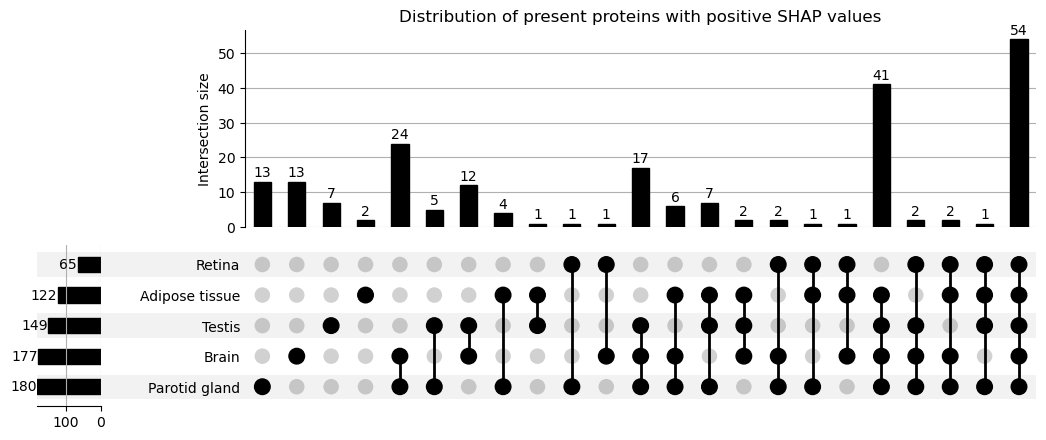

In [34]:
positive_shap_df = shap_df.loc[:, (shap_df > 0).any(axis=0)]
present_shap_df = positive_shap_df[(positive_shap_df.columns).intersection(set(proteins))]
binary_df = (present_shap_df != 0).astype(int)
# Transpose the dataframe so that proteins are the index and tissues are the columns
binary_df = binary_df.T.copy()
# Group by combinations of tissues and count occurrences of proteins
protein_sets = binary_df.groupby(list(binary_df.columns)).size()
# Create the upset plot
upset = UpSet(protein_sets, show_counts=True)
upset.plot()
# Show the plot
plt.title('Distribution of present proteins with positive SHAP values')
plt.show()


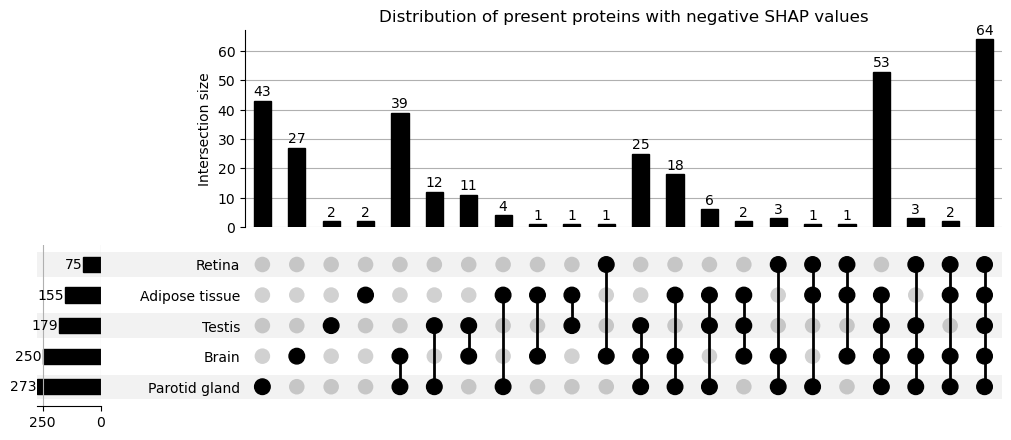

In [35]:
negative_shap_df = shap_df.loc[:, (shap_df < 0).any(axis=0)]
present_shap_df = negative_shap_df[(negative_shap_df.columns).intersection(set(proteins))]
binary_df = (present_shap_df != 0).astype(int)
# Transpose the dataframe so that proteins are the index and tissues are the columns
binary_df = binary_df.T.copy()
# Group by combinations of tissues and count occurrences of proteins
protein_sets = binary_df.groupby(list(binary_df.columns)).size()
# Create the upset plot
upset = UpSet(protein_sets, show_counts=True)
upset.plot()
# Show the plot
plt.title('Distribution of present proteins with negative SHAP values')
plt.show()


These analyses do not take the size of the SHAP values into account, for this SHAP force plots are a good visual metric

The base value is 0.04166666666666658
Testis


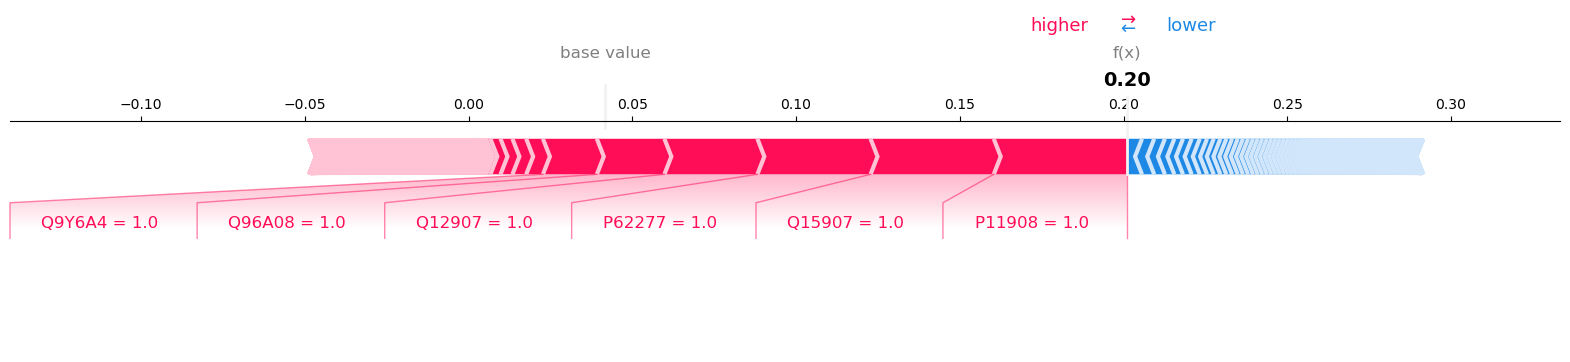

None

Retina


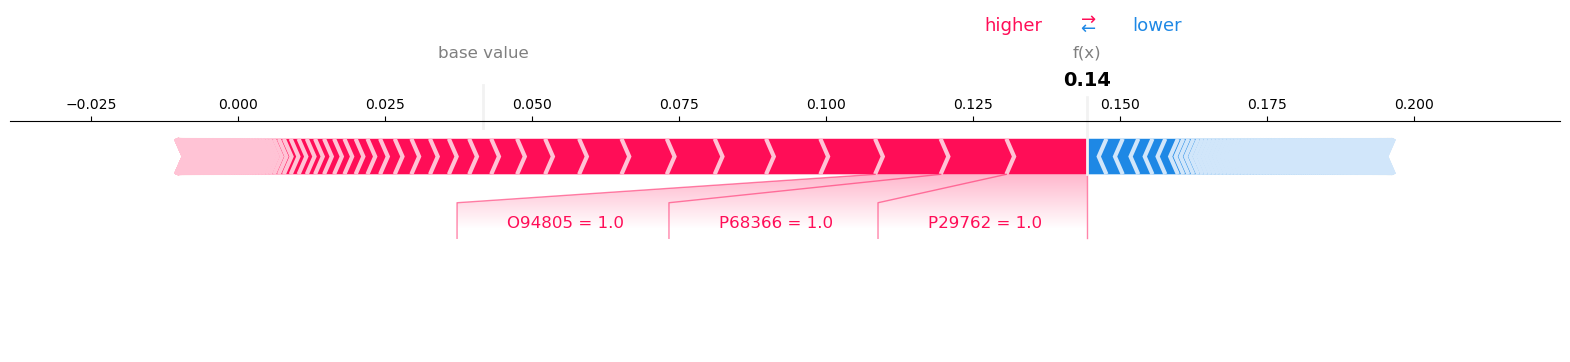

None

Parotid gland


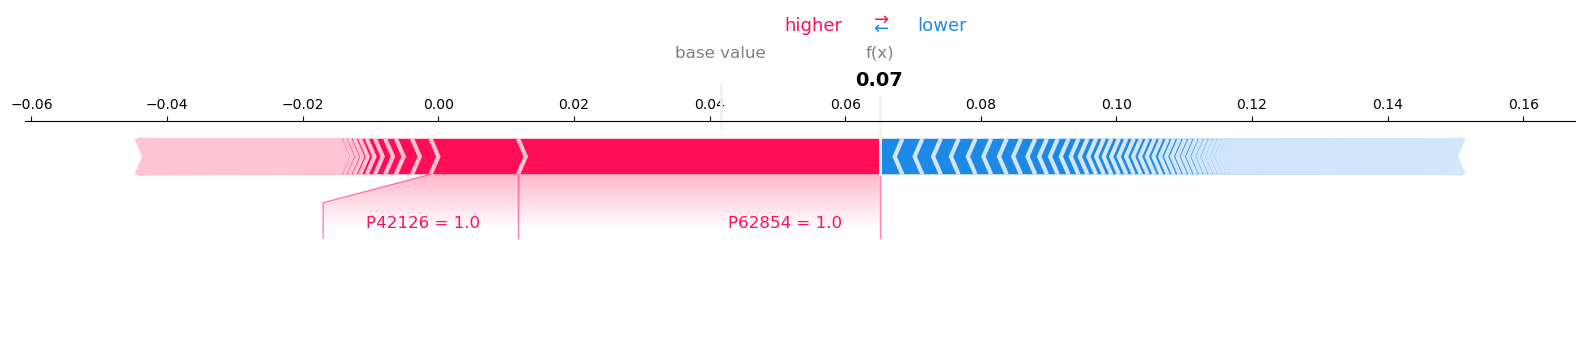

None

Brain


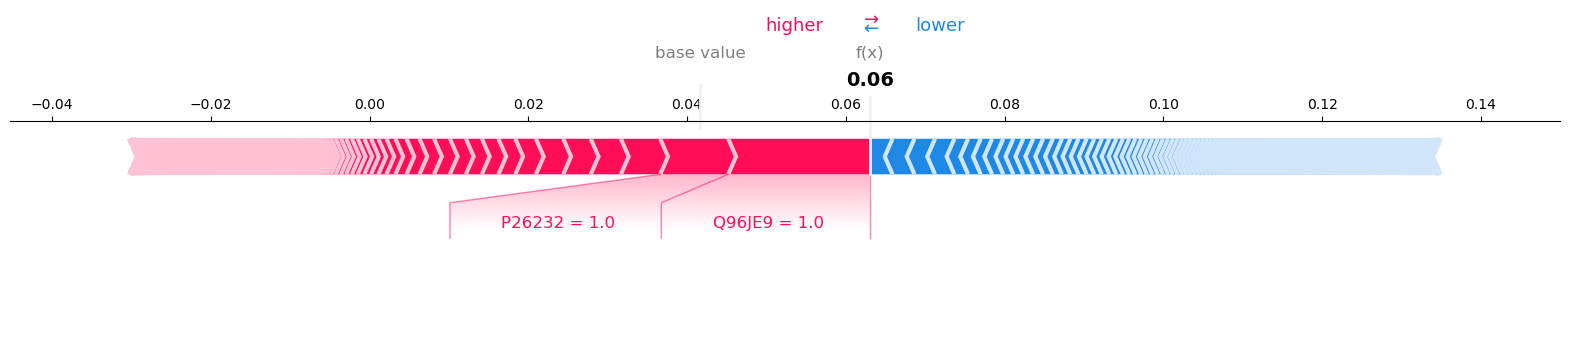

None

Adipose tissue


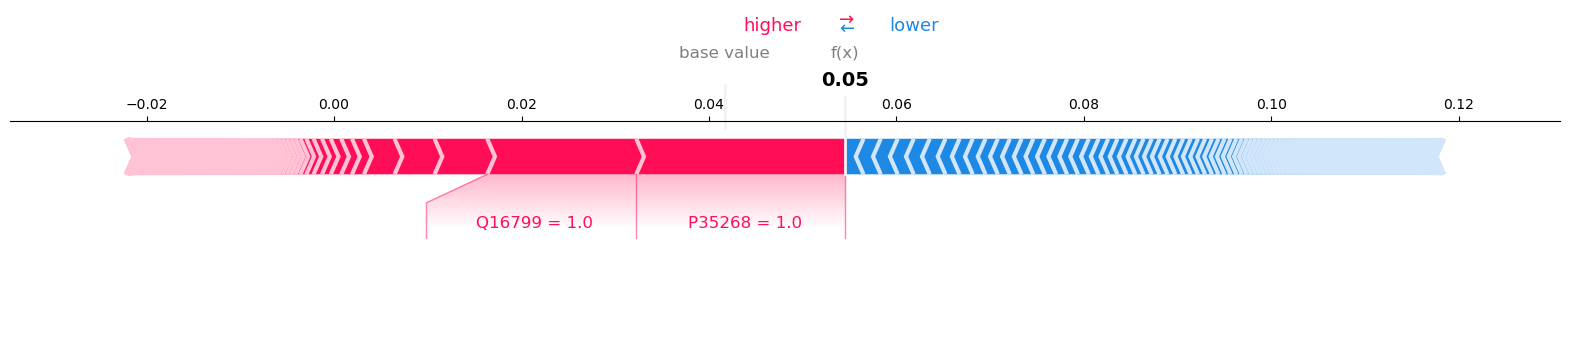

None

In [36]:
MLMarker.visualize_shap_force_plot(test, n_preds=5) 

Testis and Retina are both based on a lot of positive SHAP values contributing fairly even and not a lot of negative SHAPs. The predictions are also far from the base value.  
Going into Parotid gland, this is immedialty based on a very few positive SHAPs and a lot of negative SHAPs. The prediction is also close to the base value.
In Brain we can see more positive SHAPs. Adipose tissue is only 0.01 above the base value with a lot of negative SHAPS showing a not very confident prediction

### Most importantly: the proteins that are present in the sample and contribute to the predictions, what are they, what is their functionality?

101


Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


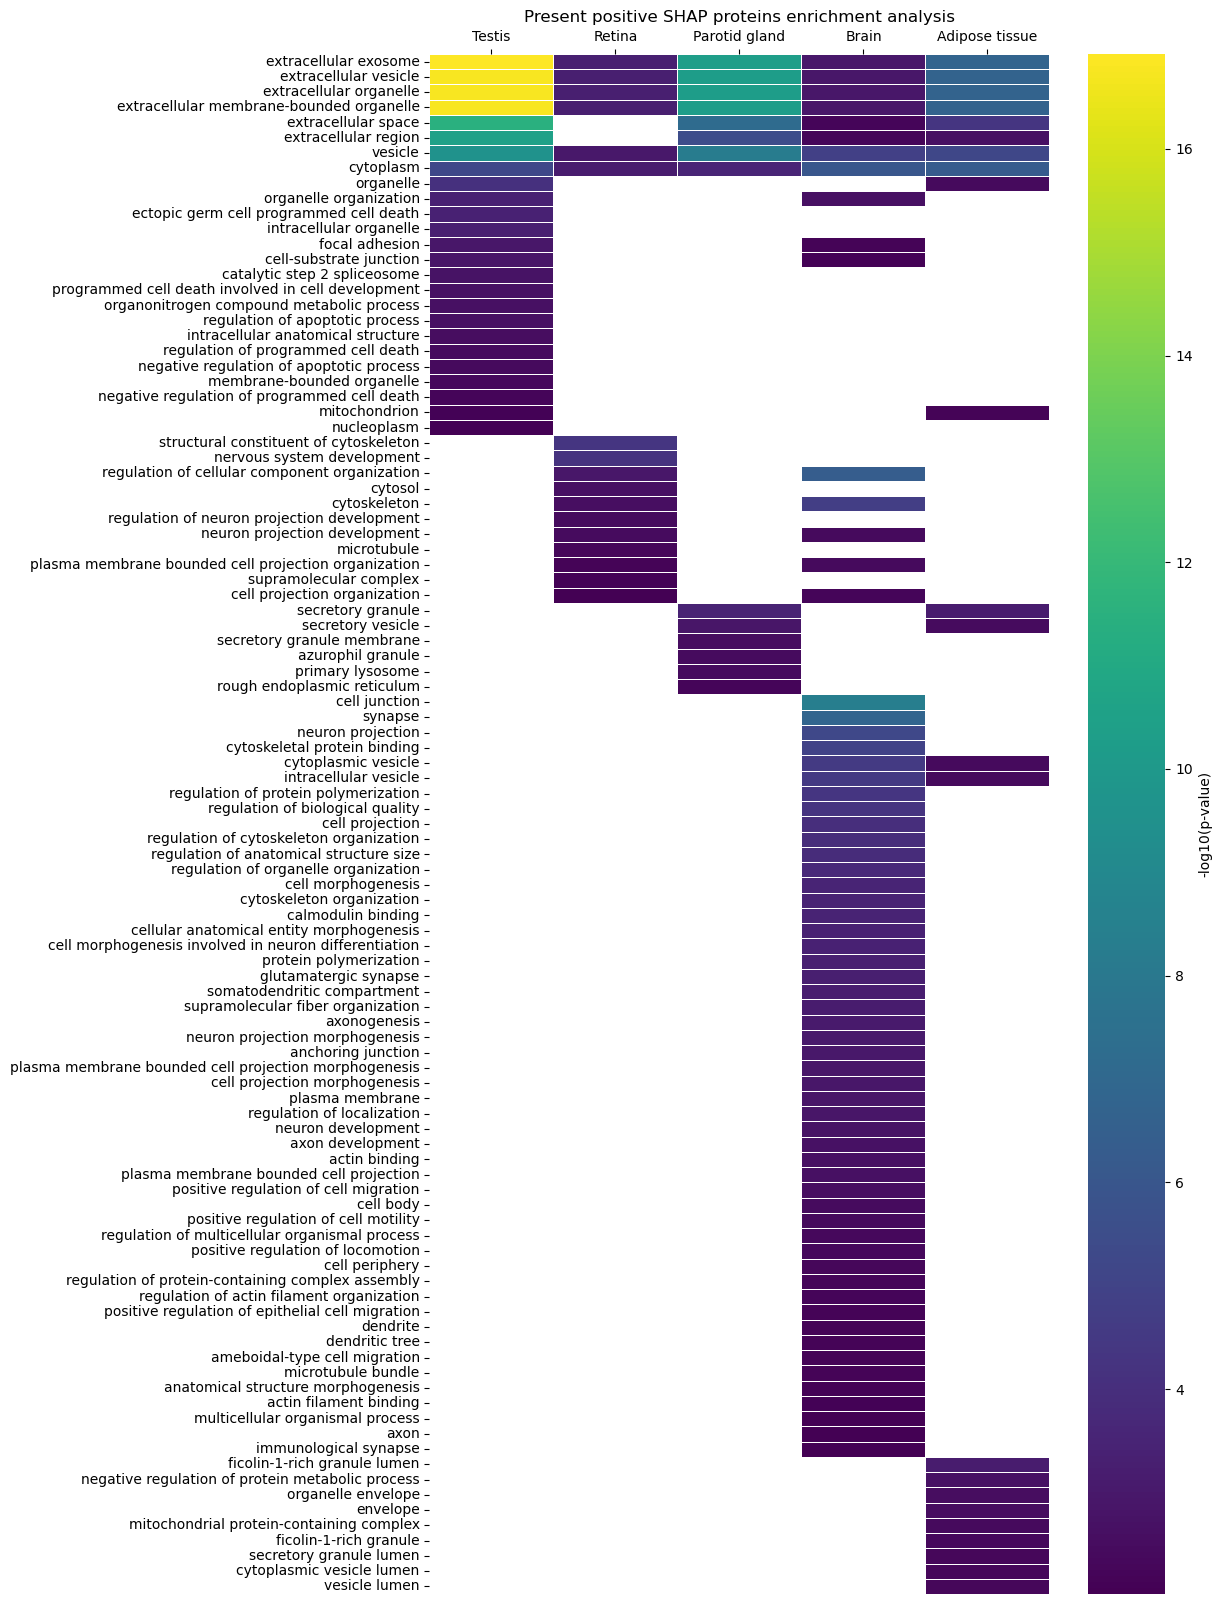

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gprofiler import GProfiler

# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

# Dictionary to store GO terms and p-values for each tissue
go_dict = {}

# List of tissues
tissues = ['Testis', 'Retina', 'Parotid gland', 'Brain', 'Adipose tissue']

# Perform GO enrichment analysis for each tissue and store p-values
for t in tissues:
    subset = present_shap_df.loc[t, :]
    positive_t_proteins = subset[subset > 0].index.tolist()
    
    # Perform GO enrichment
    results = gp.profile(organism='hsapiens', query=positive_t_proteins, sources=['GO:BP', 'GO:MF', 'GO:CC'])
    results = results[results['p_value']< 0.01]
    # Store results in the dictionary: {tissue: {GO_term: p-value}}
    go_dict[t] = dict(zip(results['name'], results['p_value']))

# Get the unique set of GO terms across all tissues
all_go_terms = list(set(go_term for go_list in go_dict.values() for go_term in go_list))
print(len(all_go_terms))
# Create a DataFrame to store p-values (rows = GO terms, columns = tissues)
go_matrix = pd.DataFrame(index=all_go_terms, columns=tissues)

# Fill the matrix with p-values from the go_dict
for tissue, go_terms in go_dict.items():
    for go_term, p_value in go_terms.items():
        go_matrix.loc[go_term, tissue] = p_value

go_matrix = go_matrix.fillna(np.nan) #log will make this zero
go_matrix = go_matrix.sort_values(by=go_matrix.columns.tolist())

# Create the heatmap
plt.figure(figsize=(10,20))
sns.heatmap(-np.log10(go_matrix.astype(float)), cmap='viridis', annot=False, 
            cbar_kws={'label': '-log10(p-value)'}, linewidths=0.5)

# Move the x-axis labels to the top
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title('Present positive SHAP proteins enrichment analysis')
# Show the plot
plt.show()


99


Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


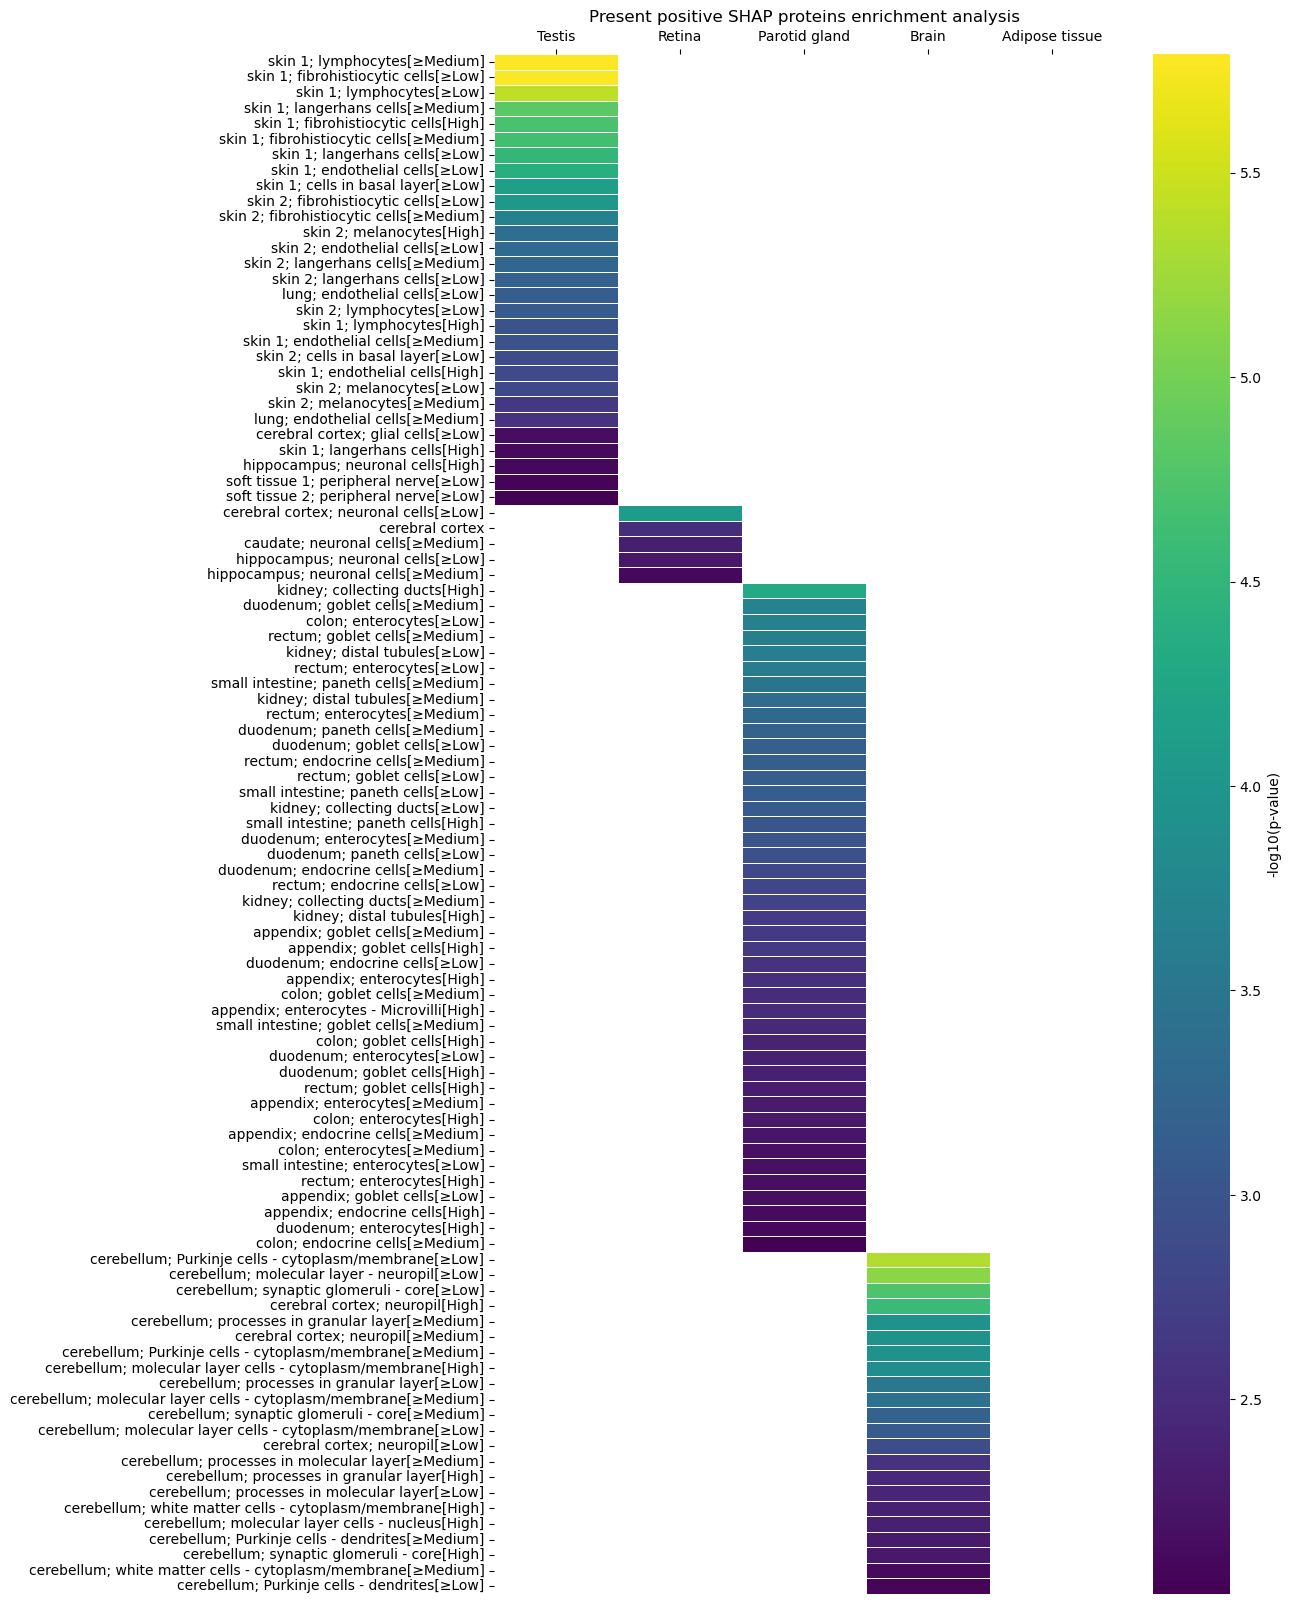

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gprofiler import GProfiler

# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

# Dictionary to store GO terms and p-values for each tissue
go_dict = {}

# List of tissues
tissues = ['Testis', 'Retina', 'Parotid gland', 'Brain', 'Adipose tissue']

# Perform GO enrichment analysis for each tissue and store p-values
for t in tissues:
    subset = present_shap_df.loc[t, :]
    positive_t_proteins = subset[subset > 0].index.tolist()
    
    # Perform GO enrichment
    results = gp.profile(organism='hsapiens', query=positive_t_proteins, sources=['HPA'])
    results = results[results['p_value']< 0.01]
    # Store results in the dictionary: {tissue: {GO_term: p-value}}
    go_dict[t] = dict(zip(results['name'], results['p_value']))

# Get the unique set of GO terms across all tissues
all_go_terms = list(set(go_term for go_list in go_dict.values() for go_term in go_list))
print(len(all_go_terms))
# Create a DataFrame to store p-values (rows = GO terms, columns = tissues)
go_matrix = pd.DataFrame(index=all_go_terms, columns=tissues)

# Fill the matrix with p-values from the go_dict
for tissue, go_terms in go_dict.items():
    for go_term, p_value in go_terms.items():
        go_matrix.loc[go_term, tissue] = p_value

go_matrix = go_matrix.fillna(np.nan) #log will make this zero
go_matrix = go_matrix.sort_values(by=go_matrix.columns.tolist())

# Create the heatmap
plt.figure(figsize=(10,20))
sns.heatmap(-np.log10(go_matrix.astype(float)), cmap='viridis', annot=False, 
            cbar_kws={'label': '-log10(p-value)'}, linewidths=0.5)

# Move the x-axis labels to the top
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title('Present positive SHAP proteins enrichment analysis')
# Show the plot
plt.show()


151


Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


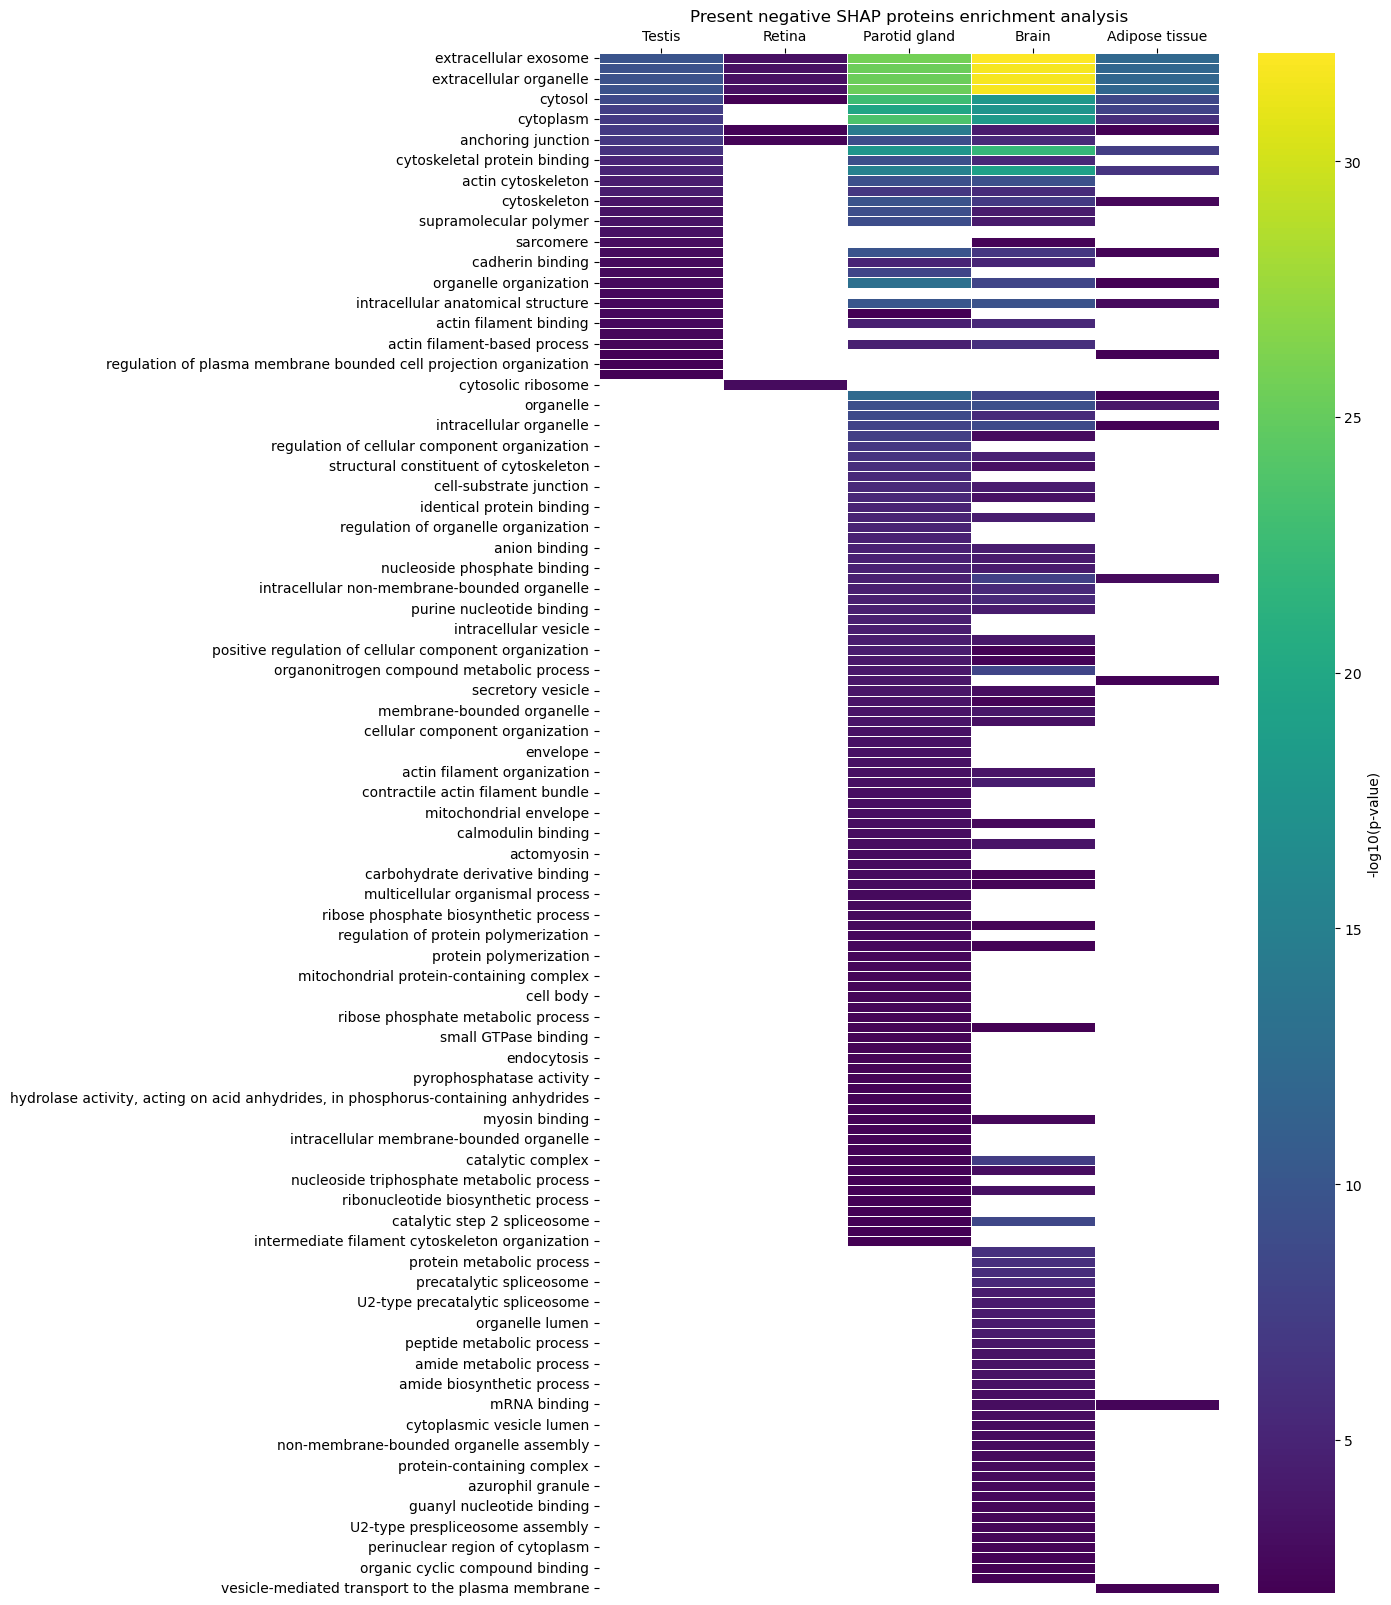

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gprofiler import GProfiler

# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

# Dictionary to store GO terms and p-values for each tissue
go_dict = {}

# List of tissues
tissues = ['Testis', 'Retina', 'Parotid gland', 'Brain', 'Adipose tissue']

# Perform GO enrichment analysis for each tissue and store p-values
for t in tissues:
    subset = present_shap_df.loc[t, :]
    positive_t_proteins = subset[subset < 0].index.tolist()
    
    # Perform GO enrichment
    results = gp.profile(organism='hsapiens', query=positive_t_proteins, sources=['GO:BP', 'GO:MF', 'GO:CC'])
    results = results[results['p_value']< 0.01]
    # Store results in the dictionary: {tissue: {GO_term: p-value}}
    go_dict[t] = dict(zip(results['name'], results['p_value']))

# Get the unique set of GO terms across all tissues
all_go_terms = list(set(go_term for go_list in go_dict.values() for go_term in go_list))
print(len(all_go_terms))
# Create a DataFrame to store p-values (rows = GO terms, columns = tissues)
go_matrix = pd.DataFrame(index=all_go_terms, columns=tissues)

# Fill the matrix with p-values from the go_dict
for tissue, go_terms in go_dict.items():
    for go_term, p_value in go_terms.items():
        go_matrix.loc[go_term, tissue] = p_value

go_matrix = go_matrix.fillna(np.nan) #log will make this zero
go_matrix = go_matrix.sort_values(by=go_matrix.columns.tolist())

# Create the heatmap
plt.figure(figsize=(10,20))
sns.heatmap(-np.log10(go_matrix.astype(float)), cmap='viridis', annot=False, 
            cbar_kws={'label': '-log10(p-value)'}, linewidths=0.5)

# Move the x-axis labels to the top
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title('Present negative SHAP proteins enrichment analysis')
# Show the plot
plt.show()


# Comparison to whole brain tissue and brain cell lines

In [43]:
t = pd.read_csv('/home/compomics/git/MLMarker/data/diseased_atlas_20240403.csv')
t.head()

,index,assay_id,cell_type,tissue_name,disease_status,fluid,A0A024RBG1,A0A075B6H7,A0A075B6H8,A0A075B6H9,...,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z4,Q9Y6Z5,Q9Y6Z7,W5XKT8
0,24,2549,Brain,Brain,Diseased,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25,2564,Brain,Brain,Diseased,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26,2838,Brain,Brain,Diseased,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27,2992,Brain,Brain,Diseased,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,3230,Brain,Brain,Diseased,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
features[-1]

'Q9Y6Y8'

In [45]:
features_path = "/home/compomics/git/MLMarker/models/binary_features_TP_4000features_95to75missingness_2024.txt"
with open(features_path, 'r') as features_file:
    features = features_file.read().split(',\n')
t = t[t.columns.intersection(features).tolist().append(['index','assay_id','cell_type','tissue_name','disease_status'])]

KeyError: None